# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the current final version...

- [x] Exploring the data: looking at the truth distributions and event image representations.
- [x] Quality cuts: how to simply remove background.
- [x] Which event image representation is best? 
- [x] Which training sample is best? (beam flux vs uniform)
- [ ] Different model architectures: which works best.
- [ ] Trying a multi-task model: what to include.
- [ ] Model calibration sensitivity: can we shift things up and down?
- [ ] Neutrino energy estimation: which model to use.
- [x] Explanation: unsupervised category clustering, activations and expected behavoir (energy dependence).
- [ ] Can we determine the primary particles?
- [ ] Final model/models performance and comparison with lagacy reco and PID

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "../config/eval.yaml"
save_path = "../data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

In [2]:
# Standard inports
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    
def save(name):
    plt.savefig('{}{}.pgf'.format(save_path, name))
    plt.savefig('{}{}.pdf'.format(save_path, name))
    plt.show()   
    
config = chipsnet.config.get(config_path)

## Exploring the data: looking at the truth distributions and event image representations.

First let's explore the input data we have to work with...

In [4]:
v_cth_flux_cos_ev, v_cth_flux_cos_out = chipsnet.utils.process_ds(config, "v_cth_flux_cos", verbose=True)
v_cth_uniform_cos_ev, v_cth_uniform_cos_out = chipsnet.utils.process_ds(config, "v_cth_uniform_cos")

Processing v_cth_flux_cos... 

Nuel:   7202, weight: 0.00540, actual: 38.88
Anuel:  7083, weight: 0.00036, actual: 2.53
Numu:   6998, weight: 0.47917, actual: 3353.22
Anumu:  6886, weight: 0.01065, actual: 73.36
Cosmic: 3831, weight: 316.027, actual: 1210697.86
Nuel-CC: total 12113, survived: 0.9277635598117725
Numu-CC: total 12006, survived: 0.7583708145927036
NC: total 4050, survived: 0.4192592592592593
Cosmic: total 3831, survived: 0.14017227877838684
took 43.83 seconds
Processing v_cth_uniform_cos... took 43.44 seconds


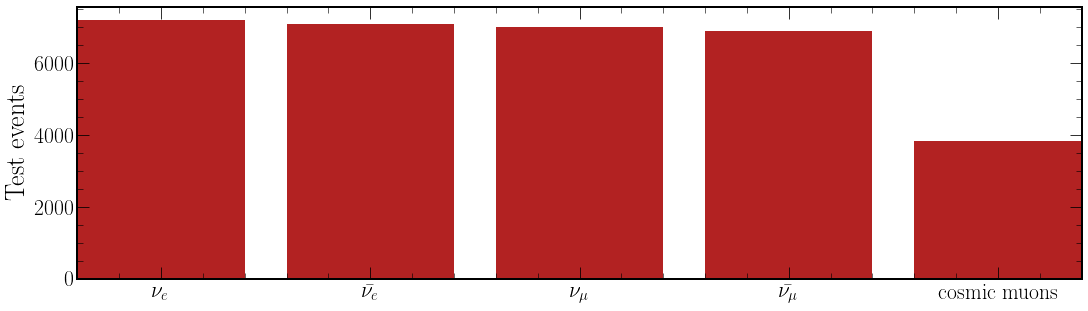

In [5]:
# change variable name for dataframes to make everything easier
events_u = v_cth_uniform_cos_ev  
events_b = v_cth_flux_cos_ev

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[events_b.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic muons'))
axs.set_ylabel("Test events")
save("nu_types")

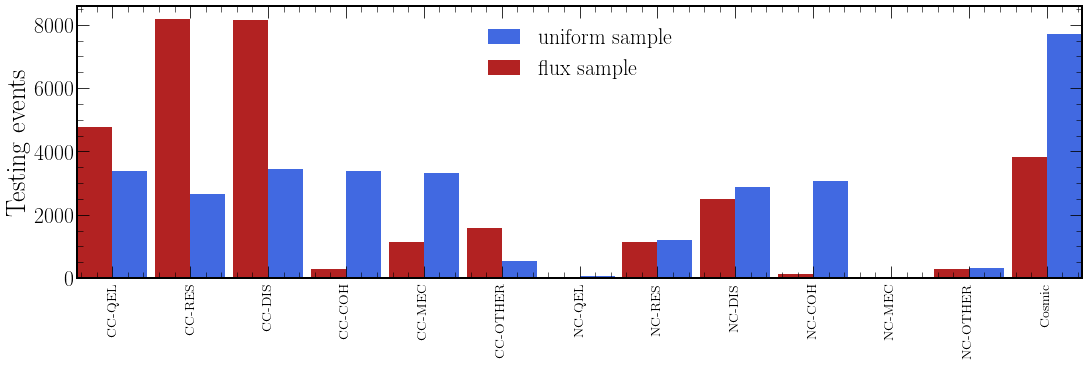

In [6]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_INT_TYPE, save_path)

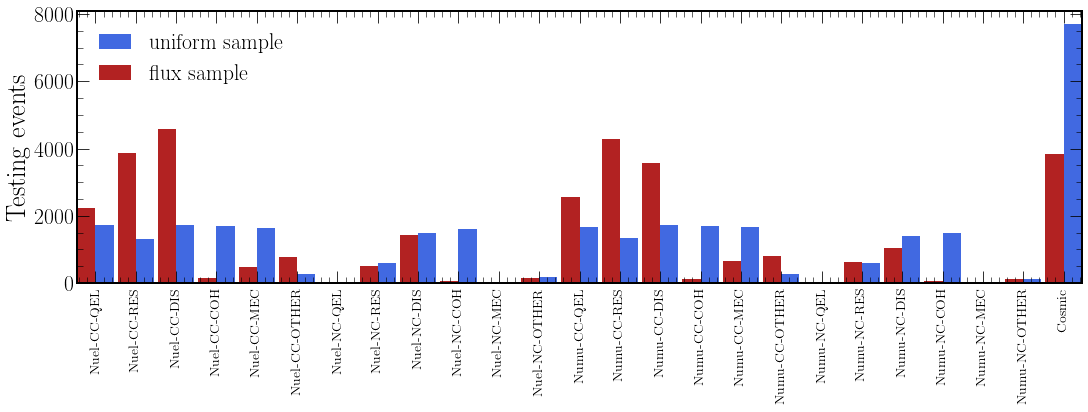

In [7]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_ALL_CAT, save_path)

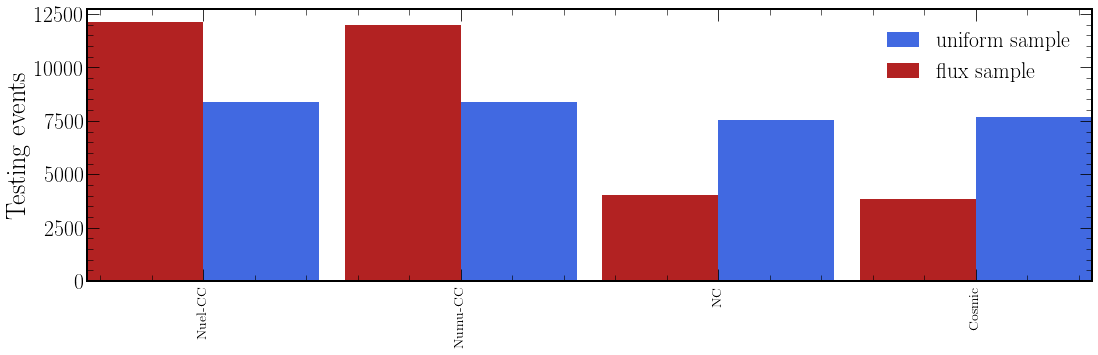

In [8]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

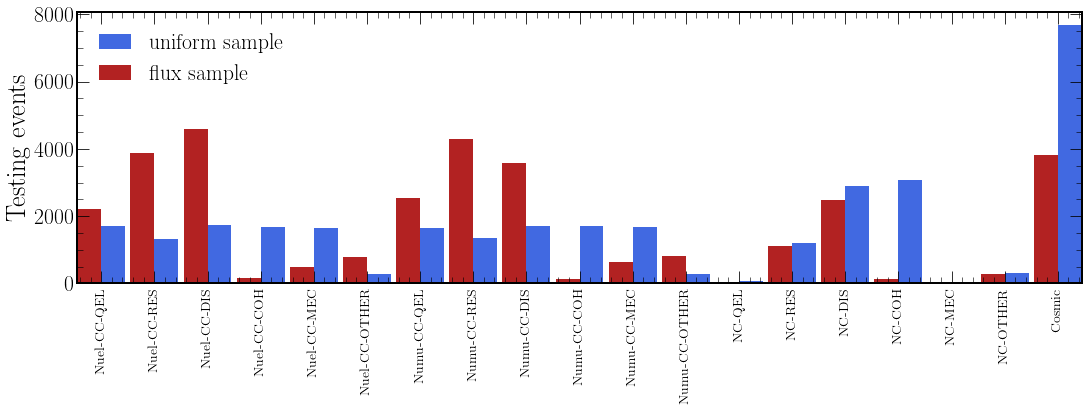

In [9]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_NU_NC_COMB_CAT, save_path)

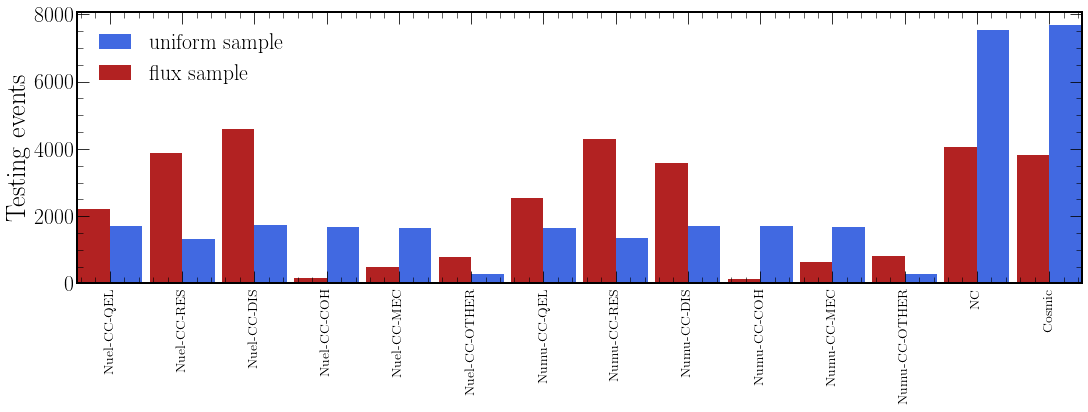

In [10]:
chipsnet.plotting.plot_cats(events_u, events_b, chipsnet.data.MAP_NC_COMB_CAT, save_path)

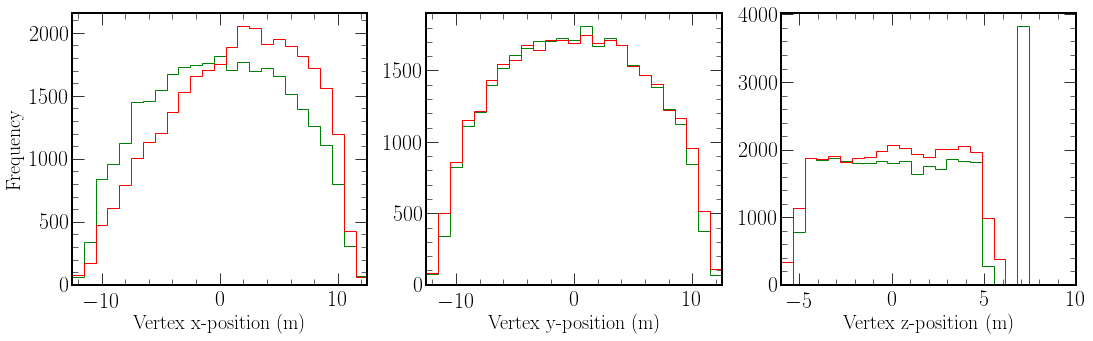

In [11]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[0].hist(events_b["r_vtxX"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[1].hist(events_b["r_vtxY"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100, range=(-6, 10), bins=25, color='green', histtype='step')
axs[2].hist(events_b["r_vtxZ"]*600/100, range=(-6, 10), bins=25, color='red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
save("vtx_positions")

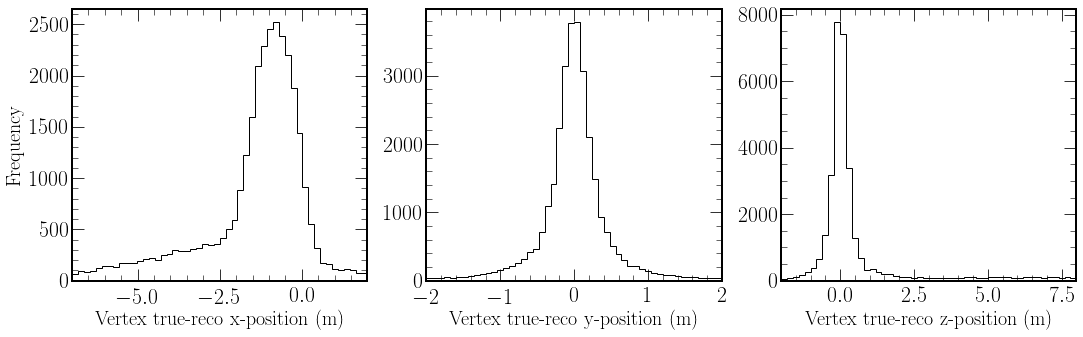

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100-(events_b["r_vtxX"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100-(events_b["r_vtxY"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100-(events_b["r_vtxZ"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
save("true_reco_vtx")

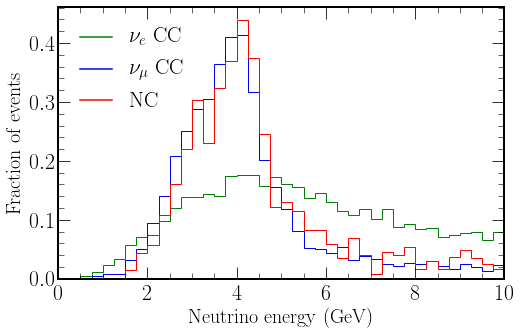

In [13]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_b = matplotlib.lines.Line2D([], [], c='blue')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(events_b[events_b["t_comb_cat"] == 0]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 0]["w"],
         range=(0, 10), bins=40, color='green', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 1]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=40, color='blue', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 2]["t_nuEnergy"]/1000, weights=events_b[events_b["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=40, color='red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["$\\nu_{e}$ CC", "$\\nu_{\mu}$ CC", "NC"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
save("nu_energies")

In [14]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_raw_charge_map_origin": [], "r_raw_charge_map_iso": [], "r_raw_charge_map_vtx": [],
               "r_raw_time_map_origin": [], "r_raw_time_map_iso": [], "r_raw_time_map_vtx": [], "r_raw_hit_hough_map_vtx": []}
channel_hists = images_dict

In [15]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.47705780747902665


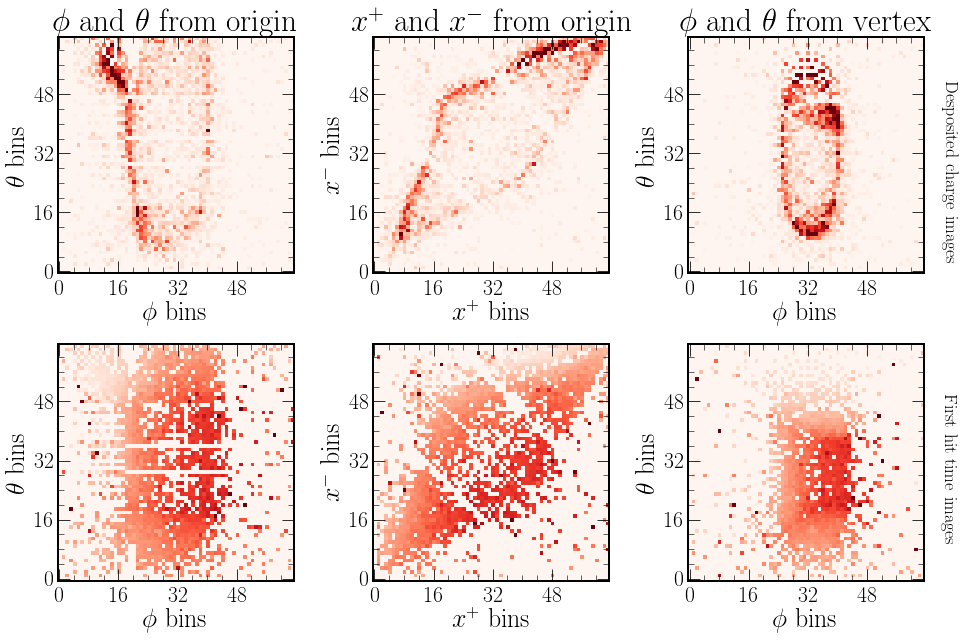

In [16]:
chipsnet.plotting.plot_hit_time(images_dict, 1, save_path)

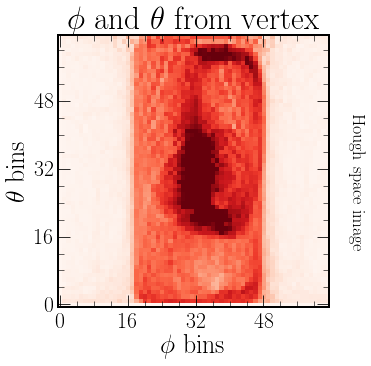

In [17]:
chipsnet.plotting.plot_hough(images_dict, 1, save_path)

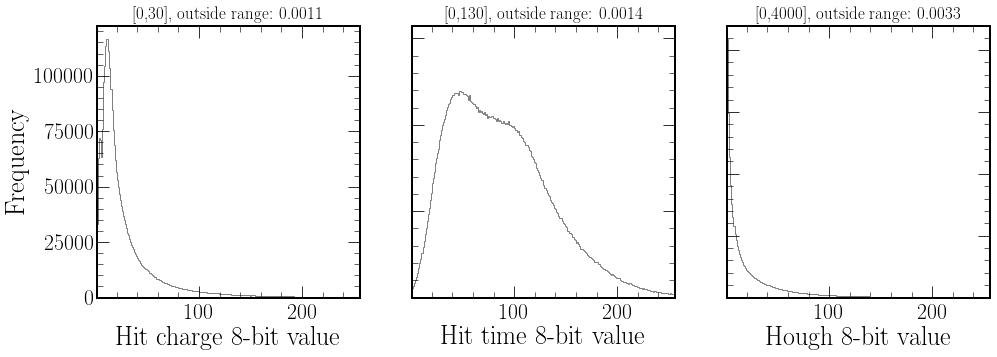

In [18]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

## Quality cuts: how to simply remove background.

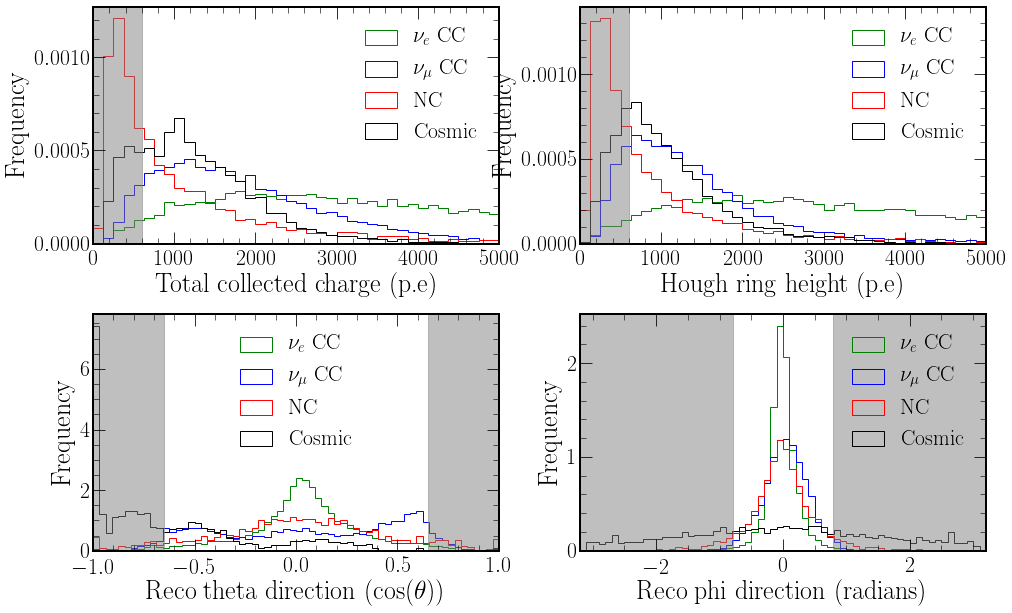

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(events_b[events_b.t_comb_cat == 0]['r_raw_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 1]['r_raw_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 2]['r_raw_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 3]['r_raw_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, config.eval.cuts.q, alpha=0.5, color='grey')
axs[0, 0].legend()

axs[0, 1].hist(events_b[events_b.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{e}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="NC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=40, density=True, label="Cosmic")
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, config.eval.cuts.h, alpha=0.5, color='grey')
axs[0, 1].legend()

axs[1, 0].hist(events_b[events_b.t_comb_cat == 0]['r_dirTheta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 1]['r_dirTheta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 2]['r_dirTheta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="NC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 3]['r_dirTheta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="Cosmic")
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -config.eval.cuts.theta, alpha=0.5, color='grey')
axs[1, 0].axvspan(config.eval.cuts.theta, 1, alpha=0.5, color='grey')
axs[1, 0].legend()

axs[1, 1].hist(events_b[events_b.t_comb_cat == 0]['r_dirPhi']*3.14159, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 1]['r_dirPhi']*3.14159, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 2]['r_dirPhi']*3.14159, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="NC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 3]['r_dirPhi']*3.14159, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="Cosmic")
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -config.eval.cuts.phi*3.14159, alpha=0.5, color='grey')
axs[1, 1].axvspan(config.eval.cuts.phi*3.14159, 3.2, alpha=0.5, color='grey')
axs[1, 1].legend()
save("simple_cuts")

## Which event image representation is best? 

The theta/phi representation as viewed from the roughly reconstructed event vertex position seems to work best.

In [21]:
v_ct_flux_ev, v_ct_flux_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["t_all_cat_v_ct_uniform"])
o_ct_flux_ev, o_ct_flux_out = chipsnet.utils.process_ds(config, "o_ct_flux", ["t_all_cat_o_ct_uniform"])
i_ct_flux_ev, i_ct_flux_out = chipsnet.utils.process_ds(config, "i_ct_flux", ["t_all_cat_i_ct_uniform"])

Processing v_ct_flux... 

/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


took 41.28 seconds
Processing o_ct_flux... 

/mnt/storage/jtingey/chips-net/chipsnet/utils.py:755: RuntimeWarning: invalid value encountered in true_divide
  np.add(
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:780: RuntimeWarning: invalid value encountered in true_divide
  np.add(
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:782: RuntimeWarning: invalid value encountered in true_divide
  np.square(


took 41.73 seconds
Processing i_ct_flux... took 40.93 seconds


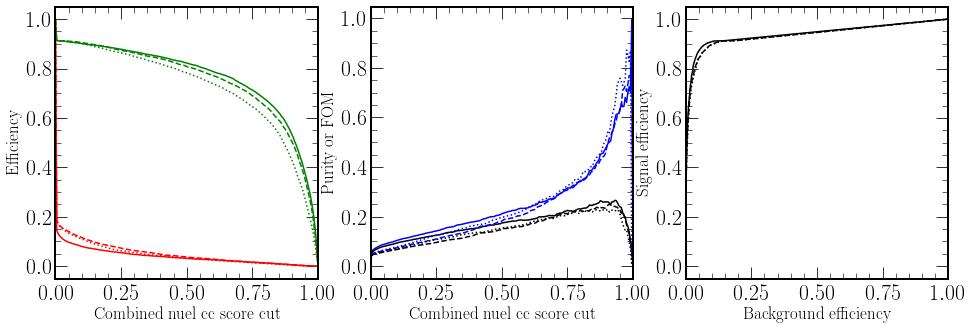

In [22]:
chipsnet.plotting.plot_curves([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], save_path+"representation_curves")

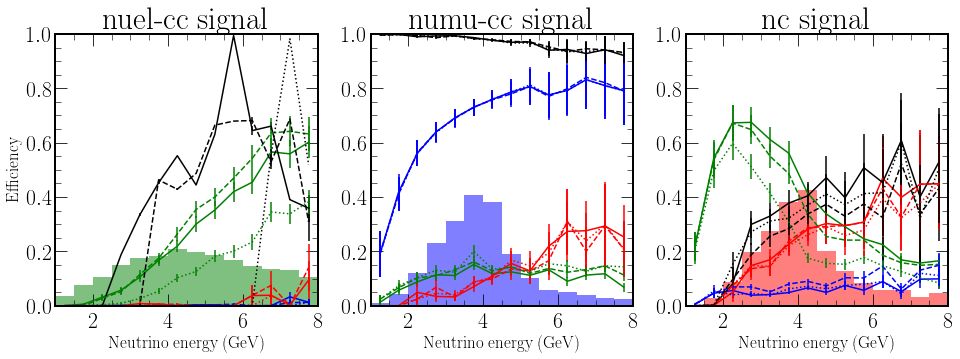

In [23]:
chipsnet.plotting.plot_e_hists([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], v_ct_flux_ev, save_path+"representation_e_hists")

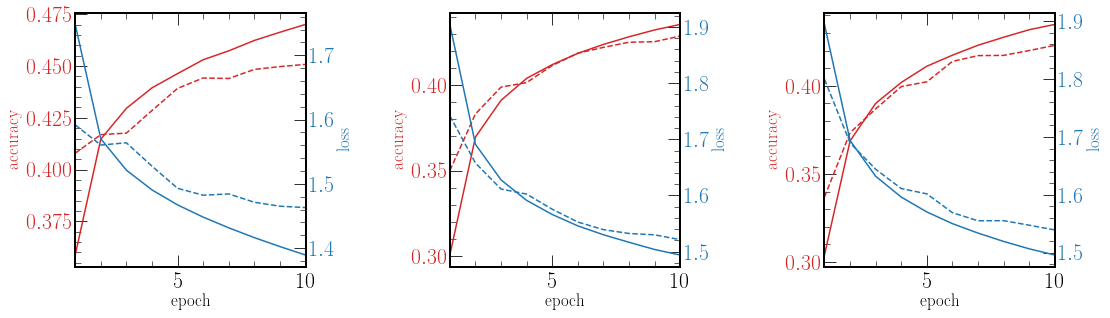

In [24]:
chipsnet.plotting.plot_history_comparison(config, ["t_all_cat_v_ct_uniform", "t_all_cat_o_ct_uniform", "t_all_cat_i_ct_uniform"], save_path+"representation_history")

In [28]:
chipsnet.utils.print_output_comparison([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out])

Sig eff AUC: [0.7630831315032554, 0.6806054296587964, 0.19932085774118372]
Bkg eff AUC: [0.040760396982159684, 0.02711139205211995, 0.03252139463749944]
Purity AUC: [0.2522688340991682, 0.9914249650597529, 0.5769203744807859]
FOM AUC: [0.16729362101693498, 0.6762379371603799, 0.10366048374856625]
ROC AUC: [0.9396947558605849, 0.8343300843173143, 0.6074030073050243]
              precision    recall  f1-score   support

     nuel-cc       0.92      0.90      0.91     13752
     numu-cc       0.98      0.93      0.95     13658
          nc       0.67      0.81      0.73      4590

    accuracy                           0.90     32000
   macro avg       0.85      0.88      0.86     32000
weighted avg       0.91      0.90      0.90     32000

              precision    recall  f1-score   support

           0       0.34      0.28      0.31      2523
           1       0.55      0.24      0.33      4413
           2       0.71      0.67      0.69      5201
           3       0.06      0.71 

## Which channels should we use?

Really doesn't look like there is any additional benefit from adding the time or the hough channel. My only reservation is that these may become more important using the full training sample size, or when using a more complex resnet or inceptions model. For now we will keep them all and see if they make a difference at all on the inception-resnet model trained on the full training dataset.

In [29]:
# Get ct from section above
v_c_flux_ev, v_c_flux_out = chipsnet.utils.process_ds(config, "v_c_flux", ["t_all_cat_v_c_uniform"])
v_cth_flux_ev, v_cth_flux_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["t_all_cat_v_cth_uniform"])

Processing v_c_flux... 

/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


took 40.30 seconds
Processing v_cth_flux... 

/mnt/storage/jtingey/chips-net/chipsnet/utils.py:755: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(pass_err, pass_h)),
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:780: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(signal_h[1], signal_h[0])),


took 41.90 seconds


/mnt/storage/jtingey/chips-net/chipsnet/utils.py:782: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


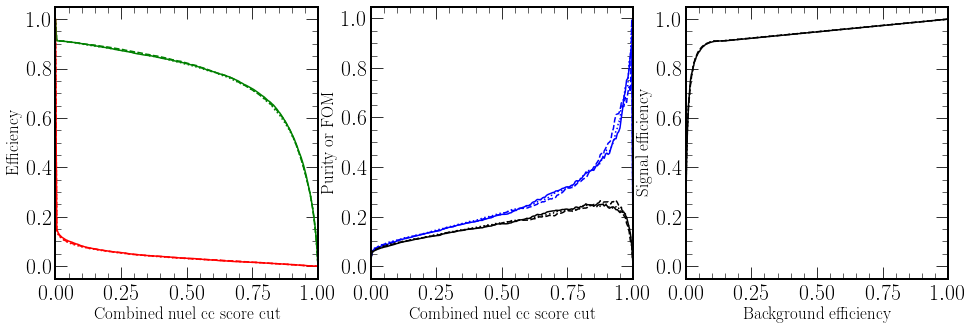

In [30]:
chipsnet.plotting.plot_curves([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], save_path+"channels_curves")

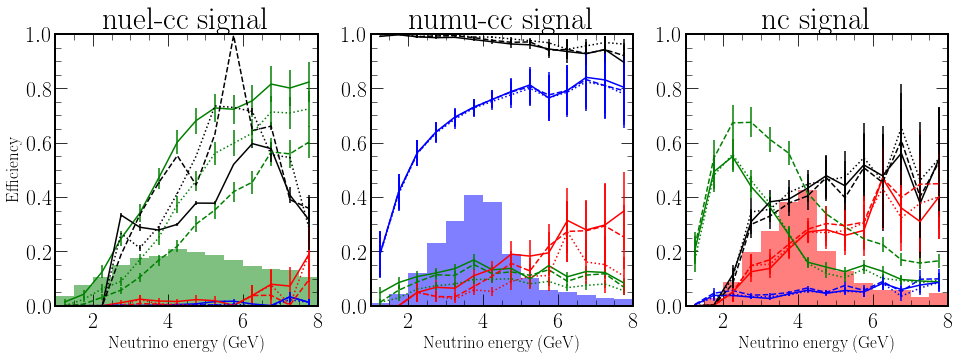

In [31]:
chipsnet.plotting.plot_e_hists([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], v_c_flux_ev, save_path+"channels_e_hists")

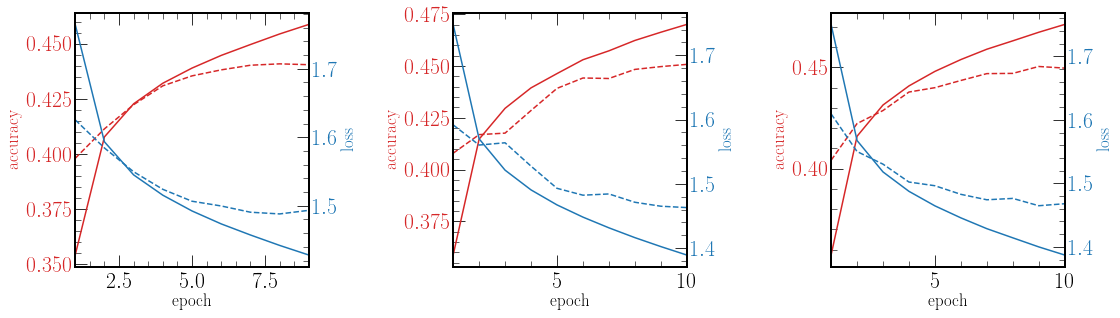

In [32]:
chipsnet.plotting.plot_history_comparison(config, ["t_all_cat_v_c_uniform", "t_all_cat_v_ct_uniform", "t_all_cat_v_cth_uniform"], save_path+"channels_history")

In [33]:
chipsnet.utils.print_output_comparison([v_c_flux_out, v_ct_flux_out, v_cth_flux_out])

Sig eff AUC: [0.7627455974748067, 0.6775943431709192, 0.19380939284241394]
Bkg eff AUC: [0.041073217517838184, 0.029158241862895996, 0.03556548259306403]
Purity AUC: [0.25188160391823944, 0.9909770967969254, 0.5490813445963003]
FOM AUC: [0.1676396059976292, 0.672905044400163, 0.09485994374093029]
ROC AUC: [0.9391829981388158, 0.832303278883757, 0.6006826391445308]
              precision    recall  f1-score   support

     nuel-cc       0.92      0.90      0.91     13752
     numu-cc       0.97      0.92      0.95     13658
          nc       0.66      0.81      0.72      4590

    accuracy                           0.90     32000
   macro avg       0.85      0.88      0.86     32000
weighted avg       0.91      0.90      0.90     32000

              precision    recall  f1-score   support

           0       0.35      0.30      0.32      2523
           1       0.52      0.22      0.31      4413
           2       0.69      0.67      0.68      5201
           3       0.05      0.73  

## Which training sample is best? (beam flux vs uniform)

Looks like the beam flux sample is best. However this seems to be because it has a larger sample of 

In [34]:
# Reuse uniform model from above
v_cth_flux_ev_flux, v_cth_flux_out_flux = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_all_cat_v_cth_flux"])
v_cth_flux_ev_uniform, v_cth_flux_out_uniform = v_cth_flux_ev, v_cth_flux_out

Processing v_cth_flux... 

/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


took 43.24 seconds


/mnt/storage/jtingey/chips-net/chipsnet/utils.py:755: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(pass_err, pass_h)),
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:780: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(signal_h[1], signal_h[0])),
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:782: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


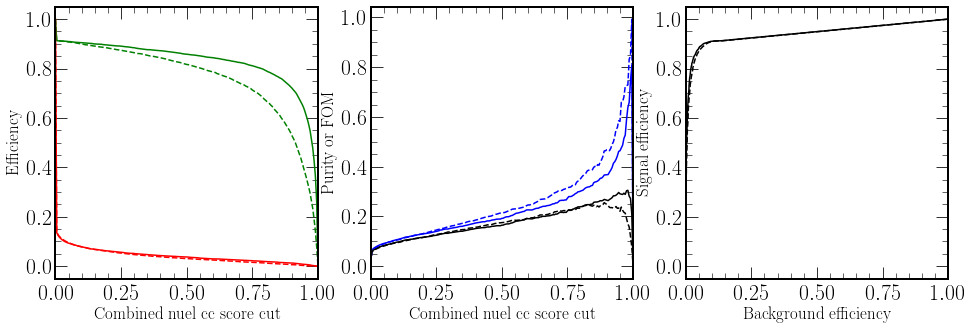

In [35]:
chipsnet.plotting.plot_curves([v_cth_flux_out_flux, v_cth_flux_out_uniform], save_path+"sample_curves")

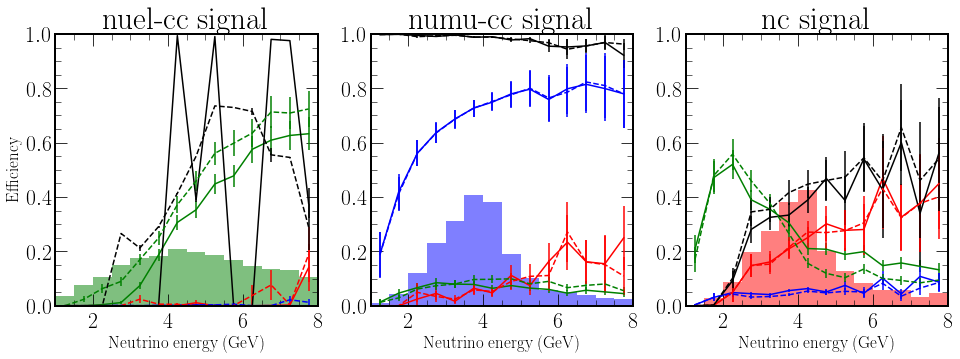

In [36]:
chipsnet.plotting.plot_e_hists([v_cth_flux_out_flux, v_cth_flux_out_uniform], v_cth_flux_ev_flux, save_path+"sample_e_hists")

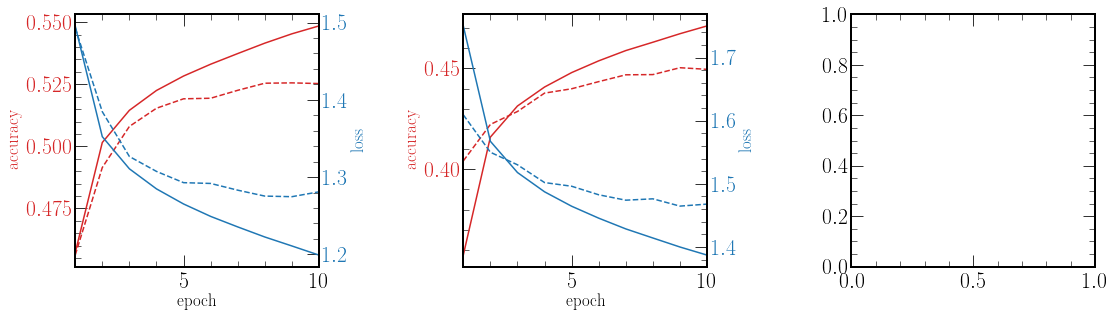

In [37]:
chipsnet.plotting.plot_history_comparison(config, ["t_all_cat_v_cth_flux", "t_all_cat_v_cth_uniform"], save_path+"sample_history")

In [38]:
chipsnet.utils.print_output_comparison([v_cth_flux_out_flux, v_cth_flux_out_uniform])

Sig eff AUC: [0.8276675213362301, 0.6876700522183834, 0.1541504663440719]
Bkg eff AUC: [0.0437894175396435, 0.036637664459297836, 0.02663971664383134]
Purity AUC: [0.22365021464632023, 0.9892790021264615, 0.5801054658085294]
FOM AUC: [0.17383577954449417, 0.6817623412854854, 0.07774030160804468]
ROC AUC: [0.9422700102273557, 0.8324588496187482, 0.6088125640776726]
              precision    recall  f1-score   support

     nuel-cc       0.91      0.94      0.92     13752
     numu-cc       0.96      0.94      0.95     13658
          nc       0.75      0.72      0.74      4590

    accuracy                           0.91     32000
   macro avg       0.87      0.87      0.87     32000
weighted avg       0.91      0.91      0.91     32000

              precision    recall  f1-score   support

           0       0.42      0.75      0.54      2523
           1       0.49      0.49      0.49      4413
           2       0.70      0.70      0.70      5201
           3       0.00      0.00  

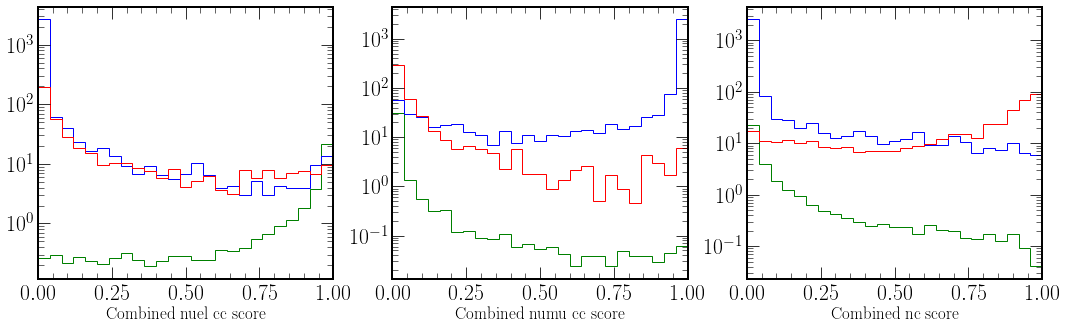

In [39]:
chipsnet.plotting.plot_combined_values(v_cth_flux_ev_flux, "t_all_cat_v_cth_flux_", save_path+"t_all_cat_v_cth_flux_values")

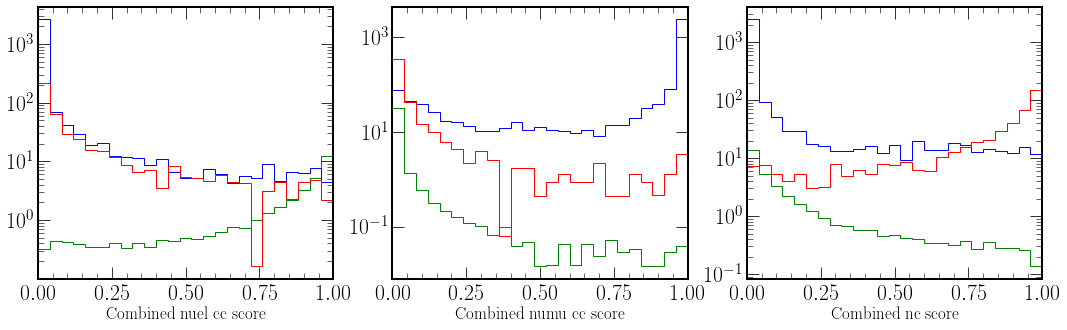

In [40]:
chipsnet.plotting.plot_combined_values(v_cth_flux_ev_uniform, "t_all_cat_v_cth_uniform_", save_path+"t_all_cat_v_cth_flux_values")

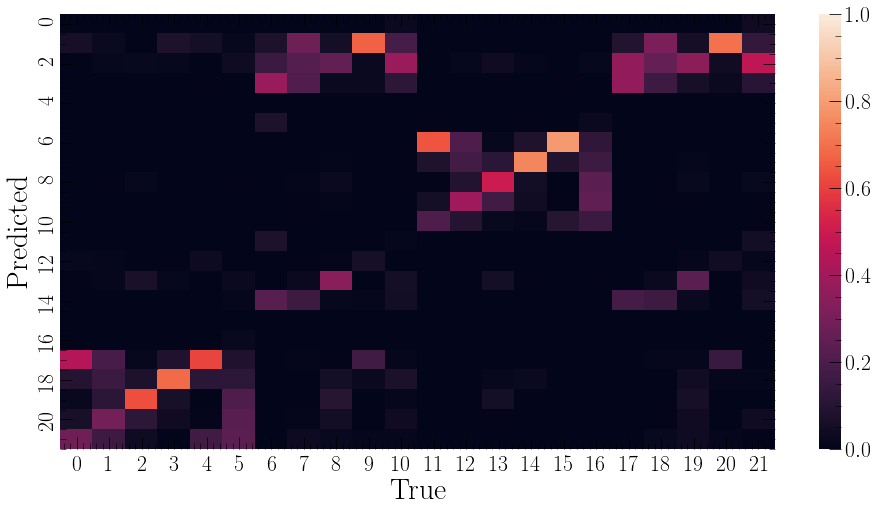

In [49]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_uniform["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

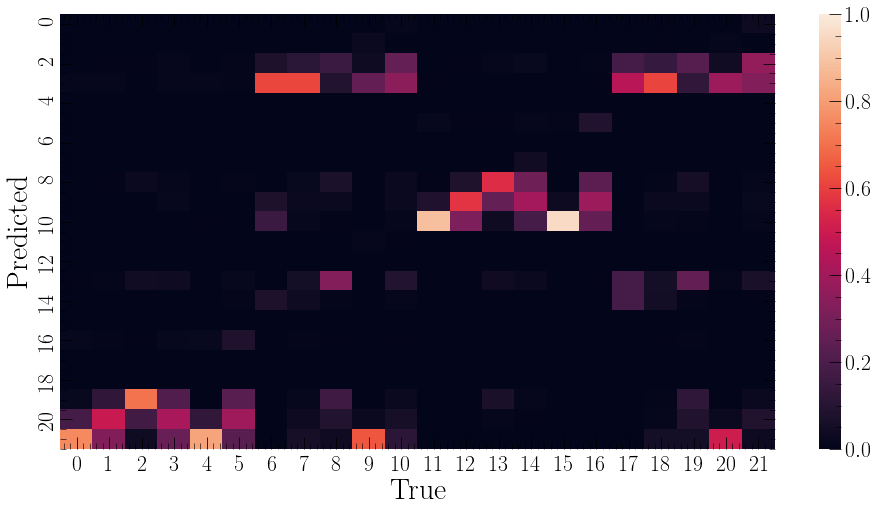

In [50]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_flux["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

## Which categorisation works best?

In [43]:
v_cth_flux_ev_all, v_cth_flux_out_all = v_cth_flux_ev, v_cth_flux_out
v_cth_flux_ev_comb, v_cth_flux_out_comb = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_comb_cat_v_cth_uniform"], ["t_comb_cat"])
v_cth_flux_ev_nu_nc, v_cth_flux_out_nu_nc = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_nu_nc_cat_v_cth_uniform"], ["t_nu_nc_cat"])
v_cth_flux_ev_nc, v_cth_flux_out_nc = chipsnet.utils.process_ds(config, "v_cth_flux", ["t_nc_cat_v_cth_uniform"], ["t_nc_cat"])

Processing v_cth_flux... took 25.66 seconds
Processing v_cth_flux... 

/mnt/storage/jtingey/chips-net/chipsnet/utils.py:755: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(pass_err, pass_h)),
/mnt/storage/jtingey/chips-net/chipsnet/utils.py:780: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(signal_h[1], signal_h[0])),


took 37.88 seconds
Processing v_cth_flux... 

/mnt/storage/jtingey/chips-net/chipsnet/utils.py:782: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


took 34.34 seconds


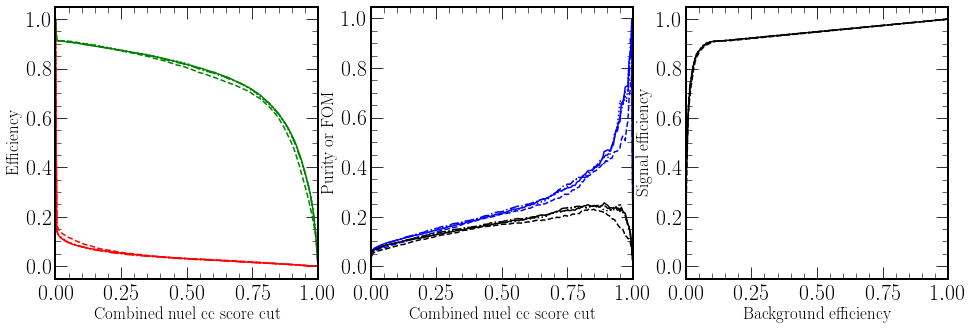

In [44]:
chipsnet.plotting.plot_curves([v_cth_flux_out_all, v_cth_flux_out_comb, v_cth_flux_out_nu_nc, v_cth_flux_out_nc], save_path+"cat_curves")

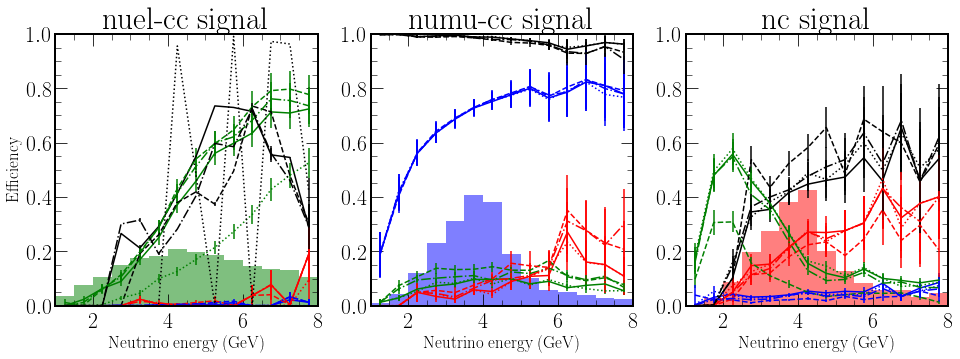

In [45]:
chipsnet.plotting.plot_e_hists([v_cth_flux_out_all, v_cth_flux_out_comb, v_cth_flux_out_nu_nc, v_cth_flux_out_nc], v_cth_flux_ev_all, save_path+"cat_e_hists")

In [46]:
chipsnet.utils.print_output_comparison([v_cth_flux_out_all, v_cth_flux_out_comb, v_cth_flux_out_nu_nc, v_cth_flux_out_nc])

Sig eff AUC: [0.7601021024855938, 0.6783972153923858, 0.2031919217160863]
Bkg eff AUC: [0.03982987993442919, 0.02543266692875412, 0.035471566734836396]
Purity AUC: [0.25511054372315056, 0.9918182381531742, 0.5466366899494741]
FOM AUC: [0.16853993091548045, 0.6743057257236134, 0.10136568079569305]
ROC AUC: [0.9397054996155938, 0.8343065834719119, 0.6049012770555694]
              precision    recall  f1-score   support

     nuel-cc       0.92      0.90      0.91     13752
     numu-cc       0.98      0.92      0.95     13658
          nc       0.65      0.82      0.73      4590

    accuracy                           0.90     32000
   macro avg       0.85      0.88      0.86     32000
weighted avg       0.91      0.90      0.90     32000

              precision    recall  f1-score   support

           0       0.35      0.28      0.31      2523
           1       0.52      0.29      0.38      4413
           2       0.73      0.63      0.68      5201
           3       0.06      0.69 

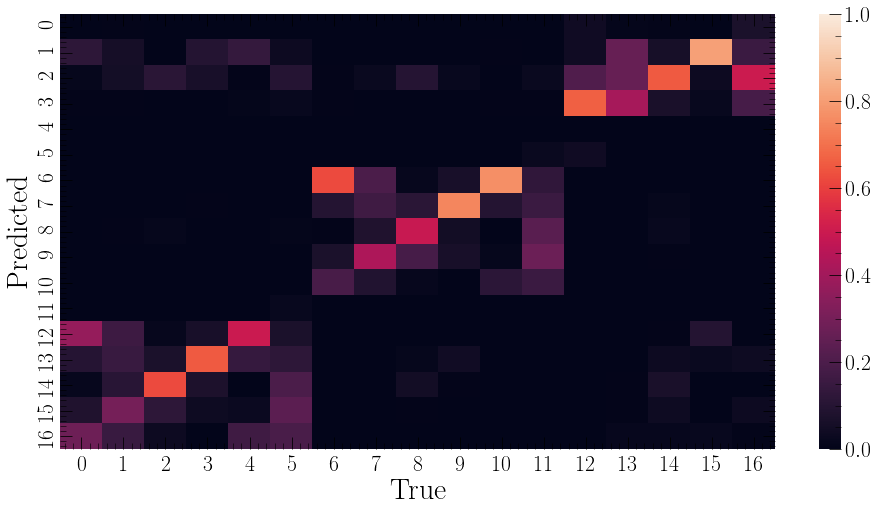

In [47]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_nu_nc["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

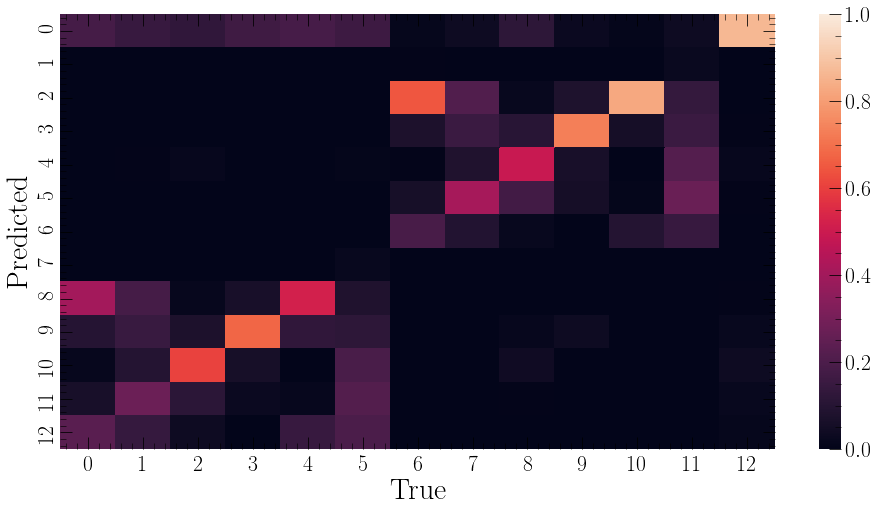

In [48]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out_nc["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

## Different model architectures: which works best.

## Trying a multi-task model: what to include.

## Model calibration sensitivity: can we shift things up and down?

## Neutrino energy estimation: which model to use.

## Explanation: unsupervised category clustering, activations and expected behavoir (energy dependence).

In [51]:
v_cth_uniform_ev, v_cth_uniform_out = chipsnet.utils.process_ds(config, "v_cth_uniform", ["t_all_cat_v_cth_uniform"])

Processing v_cth_uniform... took 51.99 seconds


/mnt/storage/jtingey/chips-net/chipsnet/utils.py:755: RuntimeWarning: invalid value encountered in true_divide
  np.square(np.divide(pass_err, pass_h)),


Explained variation per principal component: [0.15007766 0.13073224]


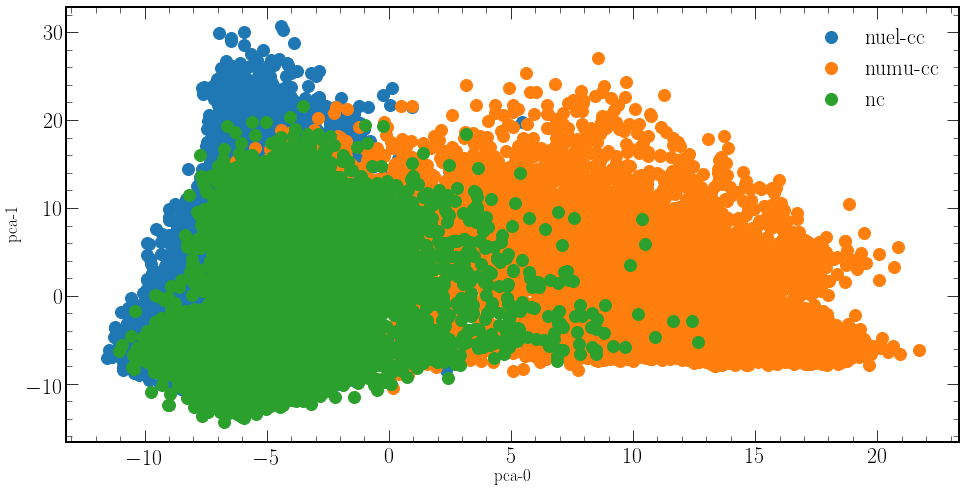

In [52]:
pca_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
v_cth_uniform_ev = chipsnet.utils.run_pca(v_cth_uniform_ev, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca_0, cat_0_ev.pca_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.pca_0, cat_1_ev.pca_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.pca_0, cat_2_ev.pca_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('pca-0', fontsize=17)
axs.set_ylabel('pca-1', fontsize=17)
save("pca")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.177s...
[t-SNE] Computed neighbors for 10000 samples in 133.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.930112
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.306114
[t-SNE] KL divergence after 300 iterations: 2.579533


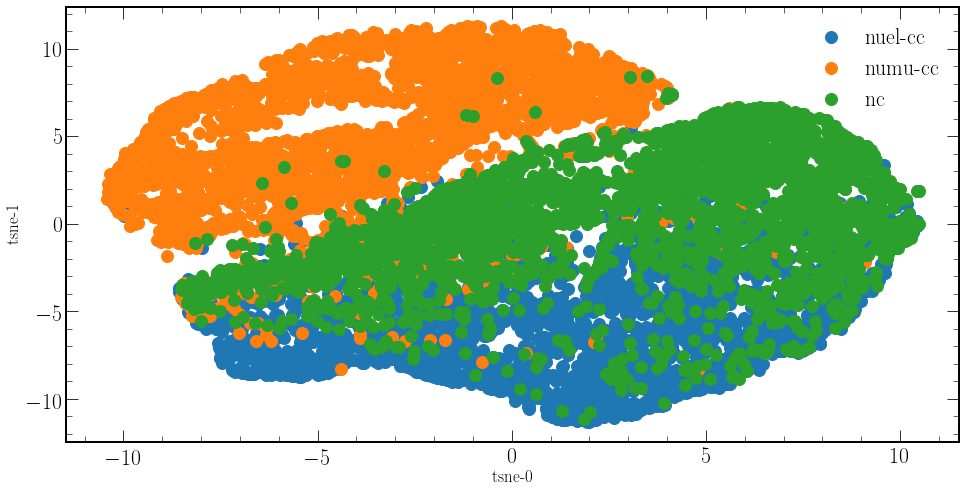

In [53]:
tsne_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
v_cth_uniform_ev = chipsnet.utils.run_tsne(v_cth_uniform_ev, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne_0, cat_0_ev.tsne_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.tsne_0, cat_1_ev.tsne_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.tsne_0, cat_2_ev.tsne_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('tsne-0', fontsize=17)
axs.set_ylabel('tsne-1', fontsize=17)
save("tsne")

In [54]:
grad_cam_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
grad_cams_1 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block1_path0_conv1")
grad_cams_2 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block2_conv1")
grad_cams_3 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block3_conv1")

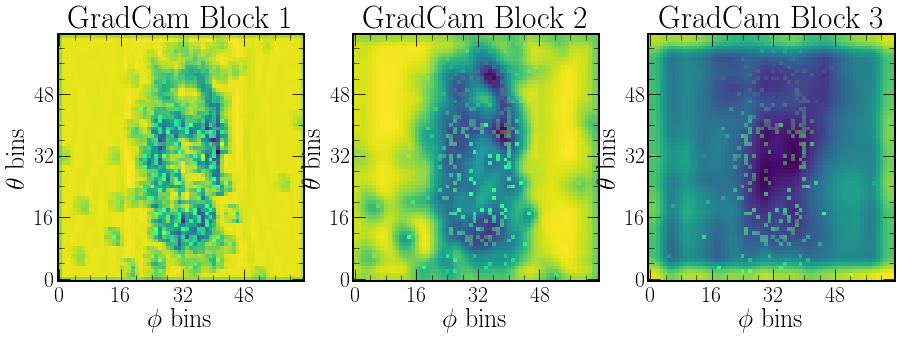

In [55]:
event = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
save("grad_cam")

In [56]:
activation_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
activations_1 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block1_path0_conv1")
activations_2 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block2_conv1")
activations_3 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block3_conv1")

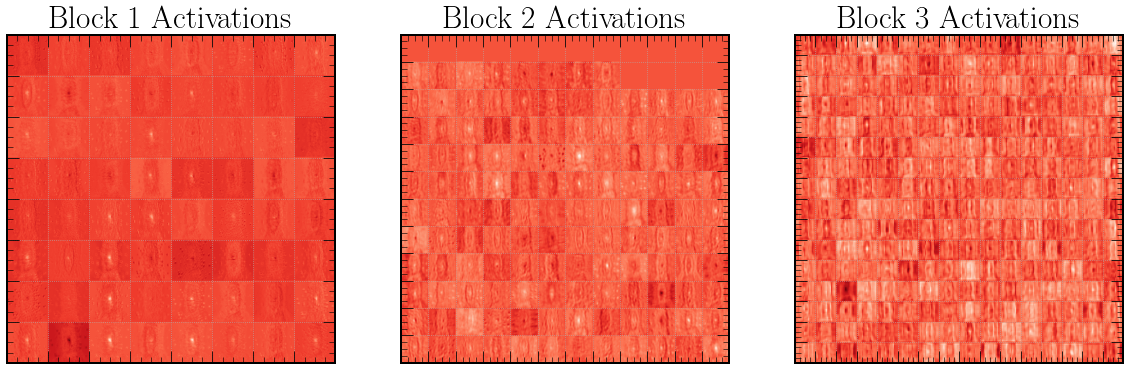

In [57]:
event = 1
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rc('grid', linestyle="-", color='black')

axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
extent = (0, 256, 256, 0)
axs[0].imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs[0].set_title('Block 1 Activations')
axs[0].grid()

extent = (0, 192, 192, 0)
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs[1].set_title('Block 2 Activations')
axs[1].grid()

extent = (0, 128, 128, 0)
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs[2].set_title('Block 3 Activations')
axs[2].grid()

save("activations")

## Can we determine the primary particles?

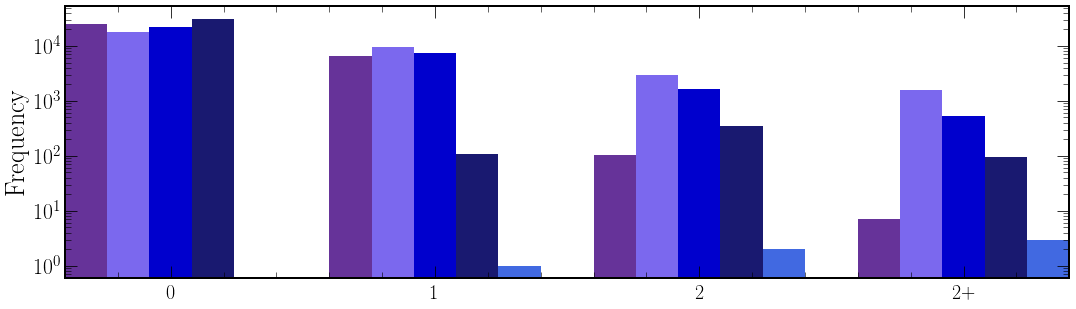

In [58]:
total_data = [len(events_b[events_b["prim_total"] == i]) for i in range(4)]
p_data = [len(events_b[events_b["prim_p"] == i]) for i in range(4)]
cp_data = [len(events_b[events_b["prim_cp"] == i]) for i in range(4)]
np_data = [len(events_b[events_b["prim_np"] == i]) for i in range(4)]
g_data = [len(events_b[events_b["prim_g"] == i]) for i in range(4)]
cats = np.arange(4)
width = 0.8

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats-(2*width/5), p_data, color="rebeccapurple", width=width/5)
axs.bar(cats-(width/5), cp_data, color="mediumslateblue", width=width/5)
axs.bar(cats, np_data, color="mediumblue", width=width/5)
axs.bar(cats+(width/5), g_data, color="midnightblue", width=width/5)
axs.bar(cats+(2*width/5), cats, color="royalblue", width=width/5)
axs.set_xticks(cats)
axs.set_xticklabels(("0", "1", "2", "2+"), fontsize=20)
axs.set_ylabel("Frequency")
axs.set_yscale('log')
plt.show()

## Final model/models performance and comparison with lagacy reco and PID